# Time-translational-invariant (TTI) Dyson

$$
(i \partial_t - H - \Sigma^R \ast ) G^{tv} = \Sigma^{tv} \ast G^M
$$

$$
\Sigma^R(t) = \xi \Sigma^{tv}(t, \beta) - \Sigma^{tv}(t,  0)
$$

$$
G^{tv}(0, \tau) = -i G^M(\beta - \tau)
$$

In [1]:
using PyPlot; plt = PyPlot
using Keldysh; kd = Keldysh;

## Integral term $\Sigma^R \ast G^{tv}$

$$
\Sigma^R \ast G^{tv} = \int_0^t d\bar{t} \, \Sigma^R(t - \bar{t}) G^{tv}(\bar{t}, \tau) 
\approx 
\Delta t \sum_{j=1}^i'
\Sigma^R(t_i - t_j) G^{tv}(t_j, \tau)
$$

Separate out boundaries

$$ 
\Sigma^R \ast G^{tv} 
=
\frac{\Delta t}{2} \Sigma^R(0) G^{tv}(t_i, \tau) 
+
\Delta t \sum_{j=2}^{i-1} \Sigma^R(t_i - t_j) G^{tv}(t_j, \tau) 
+
\frac{\Delta t}{2} \Sigma^R(t_i) G^{tv}(0, \tau)
=
\frac{\Delta t}{2} \Sigma^R(0) G^{tv}(t_i, \tau) 
+ I(t_i, \tau)
$$


In [135]:
function integrate_tti_retarded_trapz(Σ, G, t, τ)

    grid = G.grid
    dt = step(grid, forward_branch)
    
    t0 = first(grid[forward_branch])
    τ0 = first(grid[imaginary_branch])
    τβ = last(grid[imaginary_branch])
    
    norb = kd.norbitals(G)
    I = Array{ComplexF64}(undef, norb, norb)
    I .= 0.0
        
    ΣR = Int(Σ.ξ) * Σ[:, :, t, τβ] - Σ[:, :, t, τ0]
    I += 0.5 * dt * ΣR * G[:, :, t0, τ]

    for tp in grid[forward_branch][2:t.ridx - 1]
        tmtp = grid[forward_branch][t.ridx - tp.ridx + 1]
        ΣR = Int(Σ.ξ) * Σ[:, :, tmtp, τβ] - Σ[:, :, tmtp, τ0]
        I += dt * ΣR * G[:, :, tp, τ]
    end
    
    return I
    
end;

# Integral term: $\Sigma^{tv} \ast G$

$$
\Sigma^{tv} \ast G^M
=
\int_0^\beta d\bar{\tau} \, \Sigma^{tv}(t, \bar{\tau}) G^M(\bar{\tau} - \tau)
=
\int_0^\tau d\bar{\tau} \Sigma^{tv}(t, \bar{\tau}) \xi G^M(\beta + \bar{\tau} - \tau)
+
\int_\tau^\beta d\bar{\tau} \Sigma^{tv}(t, \bar{\tau}) G^M(\bar{\tau} - \tau)
= Q(t, \tau)
$$

In [136]:
function integrate_tti_mixed_trapz(Σ, G, t, τ)

    grid = G.grid
    dτ = -imag(step(grid, imaginary_branch))

    τ0 = first(grid[imaginary_branch])
    τβ = last(grid[imaginary_branch])
    
    norb = kd.norbitals(G)
    Q = Array{ComplexF64}(undef, norb, norb)
    Q .= 0.0
        
    # Trapz on the two continuous segments O(Δt^{-2})
        
    for τb in grid[imaginary_branch][τ0.ridx:τ.ridx]
        βpτbmτ = grid[imaginary_branch][τβ.ridx + τb.ridx - τ.ridx]
        s = τb.ridx == τ0.ridx || τb.ridx == τ.ridx ? 0.5 : 1.0
        Q += -im * s * dτ * Σ[:, :, t, τb] * Int(G.ξ) * G[:, :, βpτbmτ, τ0]
    end
        
    for τb in grid[imaginary_branch][τ.ridx:end]
        τbmτ = grid[imaginary_branch][τb.ridx - τ.ridx + 1]
        s = τb.ridx == τ.ridx || τb.ridx == τβ.ridx ? 0.5 : 1.0
        Q += -im * s * dτ * Σ[:, :, t, τb] * G[:, :, τbmτ, τ0]
    end
            
    # Rieman sum over discontinuity O(Δt^{-1})    
    #for τb in grid[imaginary_branch][τ0.ridx:τβ.ridx]
    #    Q += -im * dτ * Σ[:, :, t, τb] * G[:, :, τb, τ]
    #end

    return Q

end;

## Euler bwd
$$
i \partial_t G^{tv}(t_i, \tau_j) \approx \frac{i}{\Delta t} \left( G^{tv}(t_i, \tau_j) - G^{tv}(t_{i-1}, \tau_j) \right)
$$

$$
\left( \frac{i}{\Delta t} - H \right) G_0^{tv}(t_i, \tau_j) = \frac{i}{\Delta t} G_0^{tv}(t_{i-1}, \tau_j)
$$

## Implicit Trapezoidal

$$
w_{i+1} = w_i + \frac{h}{2} \left[ f_{i+1} + f_i \right]
$$

Ode form
$$
\partial_t y = f(t, y)
$$

Dyson rewritten
$$
i \partial_t G^{tv} = H G^{tv} + \Sigma^R \ast G^{tv} + \Sigma^{tv} \ast G^M
$$

## Full TTI Dyson discretization

$$
\left( \frac{i}{\Delta t} - H - \frac{\Delta t}{2} \Sigma^R(0) \right) G^{tv}(t_i, \tau) 
= 
\frac{i}{\Delta t} G^{tv}(t_{i-1}, \tau) 
+ I(t_i, \tau)
+ Q(t_i, \tau)
$$

In [137]:
using LinearAlgebra; la = LinearAlgebra

function timestep_tti_euler_bwd!(G, H, Σ, t, τ)

    grid = G.grid

    # -- Copy from imaginary time branch for t = 0
    
    if t.ridx == 1
        τ0 = first(grid[imaginary_branch])
        τβ = last(grid[imaginary_branch])
        βmτ = grid[imaginary_branch][τβ.ridx - τ.ridx + 1]
        G[:, :, t, τ] = Int(G.ξ) * G[:, :, βmτ, τ0]
        return
    end

    # -- Solve integrol diff Dyson eq. for t > 0
    
    I = integrate_tti_retarded_trapz(Σ, G, t, τ) # ΣR * Gtv
    Q = integrate_tti_mixed_trapz(Σ, G, t, τ) # Σtv * GM

    dt = step(grid, forward_branch)

    t0 = first(grid[forward_branch])
    tm1 = grid[forward_branch][t.ridx - 1] # Previous time
    
    b = 1im/dt * G[:, :, tm1, τ] + I + Q    
    A = 1im/dt * la.I - H - 0.5 * dt * Σ[:, :, t0, τ]        

    G[:, :, t, τ] = A \ b
    
end;

In [138]:
using LinearAlgebra; la = LinearAlgebra

function timestep_tti_trapz_bwd!(G, H, Σ, t, τ)

    grid = G.grid

    # -- Copy from imaginary time branch for t = 0
    
    if t.ridx == 1
        τ0 = first(grid[imaginary_branch])
        τβ = last(grid[imaginary_branch])
        βmτ = grid[imaginary_branch][τβ.ridx - τ.ridx + 1]
        G[:, :, t, τ] = Int(G.ξ) * G[:, :, βmτ, τ0]
        return
    end

    # -- Solve integrol diff Dyson eq. for t > 0
    
    tm1 = grid[forward_branch][t.ridx - 1] # Previous time

    I = integrate_tti_retarded_trapz(Σ, G, t, τ) # ΣR * Gtv
    Im1 = integrate_tti_retarded_trapz(Σ, G, tm1, τ) # ΣR * Gtv
    
    Q = integrate_tti_mixed_trapz(Σ, G, t, τ) # Σtv * GM
    Qm1 = integrate_tti_mixed_trapz(Σ, G, tm1, τ) # Σtv * GM

    dt = step(grid, forward_branch)
    t0 = first(grid[forward_branch])
    
    #b = 1im/dt * G[:, :, tm1, τ] + I + Q    
    #A = 1im/dt * la.I - H - 0.5 * dt * Σ[:, :, t0, τ]        

    b = 1im/dt * G[:, :, tm1, τ] + 0.5 * H * G[:, :, tm1, τ] + 0.5 * ( I + Im1 + Q + Qm1 ) + 0.25 * dt * Σ[:, :, t0, τ] * G[:, :, tm1, τ]
    A = 1im/dt * la.I - 0.5 * H - 0.25 * dt * Σ[:, :, t0, τ]        

    G[:, :, t, τ] = A \ b
    
end;

In [139]:
function timestep_tti!(G, H, Σ, t; euler=true)
    for τ in G.grid[imaginary_branch]
        if euler
            timestep_tti_euler_bwd!(G, H, Σ, t, τ)
        else
            timestep_tti_trapz_bwd!(G, H, Σ, t, τ)
        end
    end
end;

## Bethe lattice test

For $\Sigma$ equal to a semi-cicular spectral function (Bethe lattice) then the solution $G$ of the Dyson equation should have *exactly* the same form, up to discretization errors.

Here we use this property to study the convergence properties of the Dyson solver.

In [140]:
function solve_bethe(nt, ntau, tmax, β, t, ϵ; euler=true)
    
    c = kd.twist(kd.FullContour(tmax=tmax, β=β))
    grid = kd.FullTimeGrid(c, nt, ntau);

    Σ = kd.TimeInvariantFullTimeGF(kd.bethe_dos(t=t, ϵ=ϵ), grid);
    G = kd.TimeInvariantFullTimeGF(grid);

    G.mat.data[:] = Σ.mat.data

    H = Array{ComplexF64}(undef, 1, 1)
    H[1, 1] = ϵ

    for t in grid[forward_branch][1:end]
        timestep_tti!(G, H, Σ, t; euler=euler)
    end

    err = maximum(abs.(G.rm.data - Σ.rm.data))
    @show nt, ntau, err
    
    return err, G, Σ
end;

(nt, ntau, err) = (200, 16, 0.039810406528738275)
(nt, ntau, err) = (200, 16, 0.022281704428379873)


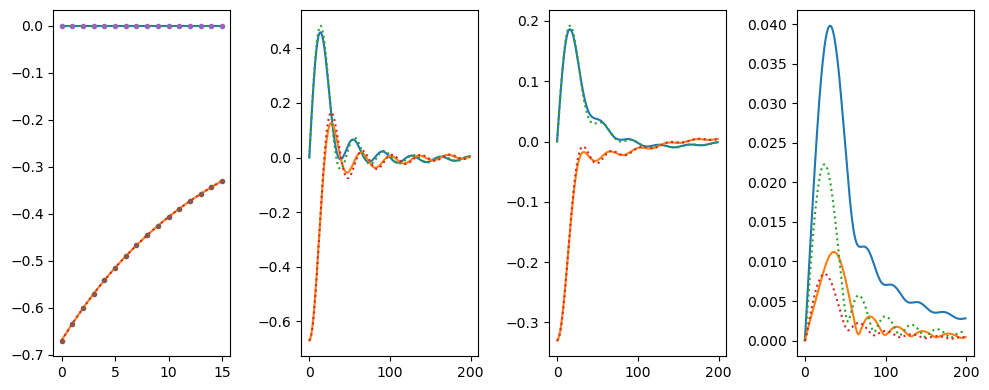

In [131]:
β = 0.5
t = 1.0
ϵ = 1.5

tmax = 10.0

ntau = 16
nt = 200 

errs, G, Σ = solve_bethe(nt, ntau, tmax, β,  t, ϵ)
errs_trapz, G_trapz, Σ_trapz = solve_bethe(nt, ntau, tmax, β,  t, ϵ; euler=false)

subp = [1, 4, 1]
plt.figure(figsize=(10, 4))

plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, :, 1]))
plt.plot(imag(G.rm.data[1, 1, :, 1]))
plt.plot(real(Σ.rm.data[1, 1, :, 1]), ":")
plt.plot(imag(Σ.rm.data[1, 1, :, 1]), ":")
plt.plot(real(G.mat.data[1, 1, :, 1]), ".")
plt.plot(imag(G.mat.data[1, 1, :, 1]), ".")

plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, 1, :]))
plt.plot(imag(G.rm.data[1, 1, 1, :]))
plt.plot(real(Σ.rm.data[1, 1, 1, :]), ":")
plt.plot(imag(Σ.rm.data[1, 1, 1, :]), ":")

plt.subplot(subp...); subp[end] += 1
plt.plot(real(G.rm.data[1, 1, end, :]))
plt.plot(imag(G.rm.data[1, 1, end, :]))
plt.plot(real(Σ.rm.data[1, 1, end, :]), ":")
plt.plot(imag(Σ.rm.data[1, 1, end, :]), ":")

plt.subplot(subp...); subp[end] += 1
plt.plot(abs.(G.rm.data[1, 1, 1, :] - Σ.rm.data[1, 1, 1, :]))
plt.plot(abs.(G.rm.data[1, 1, end, :] - Σ.rm.data[1, 1, end, :]))

plt.plot(abs.(G_trapz.rm.data[1, 1, 1, :] - Σ.rm.data[1, 1, 1, :]), ":")
plt.plot(abs.(G_trapz.rm.data[1, 1, end, :] - Σ.rm.data[1, 1, end, :]), ":")

plt.tight_layout()

(nt, ntau, err) = (2, 2, 0.2261911891462856)
(nt, ntau, err) = (4, 2, 0.12412987209555429)
(nt, ntau, err) = (8, 2, 0.06471357783165042)
(nt, ntau, err) = (16, 2, 0.0359621872518544)
(nt, ntau, err) = (32, 2, 0.022249605440255452)
(nt, ntau, err) = (64, 2, 0.0158056083643389)
(nt, ntau, err) = (128, 2, 0.012822622570321898)
(nt, ntau, err) = (256, 2, 0.011439292223842743)
(nt, ntau, err) = (2, 4, 0.22571436756748695)
(nt, ntau, err) = (4, 4, 0.1208511455864213)
(nt, ntau, err) = (8, 4, 0.060362674800192154)
(nt, ntau, err) = (16, 4, 0.0309342721705485)
(nt, ntau, err) = (32, 4, 0.0166443538705878)
(nt, ntau, err) = (64, 4, 0.009695652282682994)
(nt, ntau, err) = (128, 4, 0.0063558212342409)
(nt, ntau, err) = (256, 4, 0.0047845946221999934)
(nt, ntau, err) = (2, 8, 0.2255866450416845)
(nt, ntau, err) = (4, 8, 0.11993966282039532)
(nt, ntau, err) = (8, 8, 0.05917395126233676)
(nt, ntau, err) = (16, 8, 0.029596378947584333)
(nt, ntau, err) = (32, 8, 0.01518952932152619)
(nt, ntau, err) = 

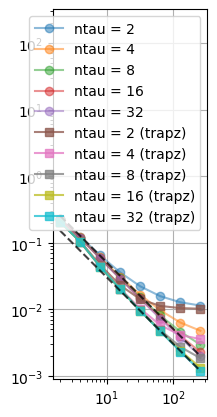

In [154]:
β = 0.1
t = 1.0
ϵ = 1.5

tmax = 1.0

ntau = 20
nts = 2 .^(1:8)
ntaus = [2, 4, 8, 16, 32]
#ntaus = [2, 4, 8]

errs_ntau = [ (ntau ,[solve_bethe(nt, ntau, tmax, β,  t, ϵ)[1] for nt in nts]) for ntau in ntaus]
errs_ntau_trapz = [ (ntau ,[solve_bethe(nt, ntau, tmax, β,  t, ϵ; euler=false)[1] for nt in nts]) for ntau in ntaus]

for (ntau, errs) in errs_ntau
    plt.plot(nts, errs, "o-", label="ntau = $ntau", alpha=0.5)
end

for (ntau, errs) in errs_ntau_trapz
    plt.plot(nts, errs, "s-", label="ntau = $ntau (trapz)", alpha=0.75)
end

ntau, errs = last(errs_ntau)
line = errs[end] .* nts[end] ./ nts
plt.plot(nts, line, "k--", alpha=0.75)

ntau, errs = last(errs_ntau_trapz)
line = errs[end] .* nts[end] ./ nts
plt.plot(nts, line, "k--", alpha=0.75)

plt.legend(loc="best")
plt.loglog([], [])
plt.grid(true)
plt.axis("square");

In [ ]:
G_ref = kd.GenericTimeGF(kd.bethe_dos(t=t, ϵ=ϵ), grid);

subp = [1, 2, 1]
plt.figure(figsize=(10, 4))
plt.subplot(subp...); subp[end] += 1
plt.pcolormesh(real(G_ref.data.data[1, 1, :, :]), vmin=-1, vmax=+1, rasterized=true)

N = 2*nt + ntau
plt.plot([0, N], [nt, nt], "r-", alpha=0.5, lw=0.5)
plt.plot([0, N], [nt + ntau , nt + ntau], "r-", alpha=0.5, lw=0.5)
plt.plot([nt, nt], [0, N], "r-", alpha=0.5, lw=0.5)
plt.plot([nt + ntau , nt + ntau], [0, N], "r-", alpha=0.5, lw=0.5)
plt.colorbar()
plt.axis("square")

plt.subplot(subp...); subp[end] += 1
plt.pcolormesh(imag(G_ref.data.data[1, 1, :, :]), vmin=-1, vmax=+1, rasterized=true)

N = 2*nt + ntau
plt.plot([0, N], [nt, nt], "r-", alpha=0.5, lw=0.5)
plt.plot([0, N], [nt + ntau , nt + ntau], "r-", alpha=0.5, lw=0.5)
plt.plot([nt, nt], [0, N], "r-", alpha=0.5, lw=0.5)
plt.plot([nt + ntau , nt + ntau], [0, N], "r-", alpha=0.5, lw=0.5)

plt.colorbar()
plt.axis("square")

In [ ]:
subp = [1, 2, 1]
plt.figure(figsize=(10, 4))
plt.subplot(subp...); subp[end] += 1
plt.pcolormesh(real(G_ref_tti.rm.data[1, 1, :, :]), vmin=-1, vmax=+1, rasterized=true)
plt.colorbar()
plt.axis("equal")

plt.subplot(subp...); subp[end] += 1
plt.pcolormesh(imag(G_ref_tti.rm.data[1, 1, :, :]), vmin=-1, vmax=+1, rasterized=true)
plt.colorbar()
plt.axis("equal")

In [ ]:
subp = [1, 2, 1]
plt.figure(figsize=(10, 4))
plt.subplot(subp...); subp[end] += 1
plt.pcolormesh(real(G.rm.data[1, 1, :, :]), vmin=-1, vmax=+1, rasterized=true)
plt.colorbar()
plt.axis("equal")

plt.subplot(subp...); subp[end] += 1
plt.pcolormesh(imag(G.rm.data[1, 1, :, :]), vmin=-1, vmax=+1, rasterized=true)
plt.colorbar()
plt.axis("equal")